# Main program GAIA-NIR

## Purpose

The main program handles the overall simulation flow by calling methods from the Spectrum and Parameters classes.\
The Spectrum class encapsulates all spectrum-related operations, including loading, processing, and saving the spectrum. \
The Parameters class handles configuration.


## Version History
- **v11.0**: Update: 

-Modified Resampling method to give the option of using a fixed pixel size if known (for example for Gaia spectra), otherwise it will calculate the pixel size.

-Modified the Rescaling method to now choose between a manual or "automatic" reference flux selection. If not provided it selects the maximum flux in the central 20% region of the spectrum.

-Modified Resample stochastic method: trimming is also now with an optional range or an automatic margin based on the velocity shift. If no range is provided for the trimming, then it is computed automatically based on a ±1000 km/s margin.


**Last Edited: 2025-05-20**


## Flowchart of first overview of program

## Main program


In [22]:
from spectrum import Spectrum
from parameters import Parameters
import logging
import os

logging.basicConfig(
    level=logging.INFO,
    format="[%(funcName)s] %(message)s",)

In [23]:
def main():
    """
    Main function to control the simulation flow.
    """
    params = Parameters.load_from_json()
    params.save_to_json()

    spectrum = Spectrum()
    spectrum.load_spectrum(params.input_file)
    spectrum.convert_units(parameters=params)

    if params.apply_convolution:
        spectrum.convolve_spectrum(parameters=params)
    
    if params.apply_resampling:
        spectrum.resample_spectrum(parameters=params)

    #WARNING: Using 100th percentile for our synthetic spectra
    #For real spectra, percentile should depend on SNR to be implemented, if necessary.
    spectrum.rescale_flux(parameters=params)

    base_name = os.path.splitext(os.path.basename(params.input_file))[0]
    
    original = spectrum.copy()
    for i in range(params.num_output_spectra):
        spectrum = original.copy()  
        logging.info("-" * 70)  
        logging.info(f"Starting iteration {i+1}/{params.num_output_spectra}")
        #Rad Vel not implemented for now.
        spectrum.radial_velocity_shift(parameters = params)  
        spectrum.resample_stochastic(parameters = params)  
        spectrum.generate_noise(parameters = params)  
        spectrum.save_spectrum(base_name=base_name, snr=params.snr, index=i+1)

    logging.info(f"Simulation complete.")


[load_from_json] Parameters loaded from 'config.json'
[load_spectrum] Loaded spectrum from 't5700g440a00x10p00_w1001_1031_combined.dat' successfully.
[convert_units] Wavelengths appear to already be in Ångströms. Skipping conversion.
[convolve_spectrum] Sigma wavelength units: 0.38 Å, pixel units: 22.15
[convolve_spectrum] Gaussian convolution completed.
[convolve_spectrum] Flux before & after convolution: 17373.938 | 17374.017
[convolve_spectrum] [convolve_spectrum] Flux conservation ratio: 1.000005


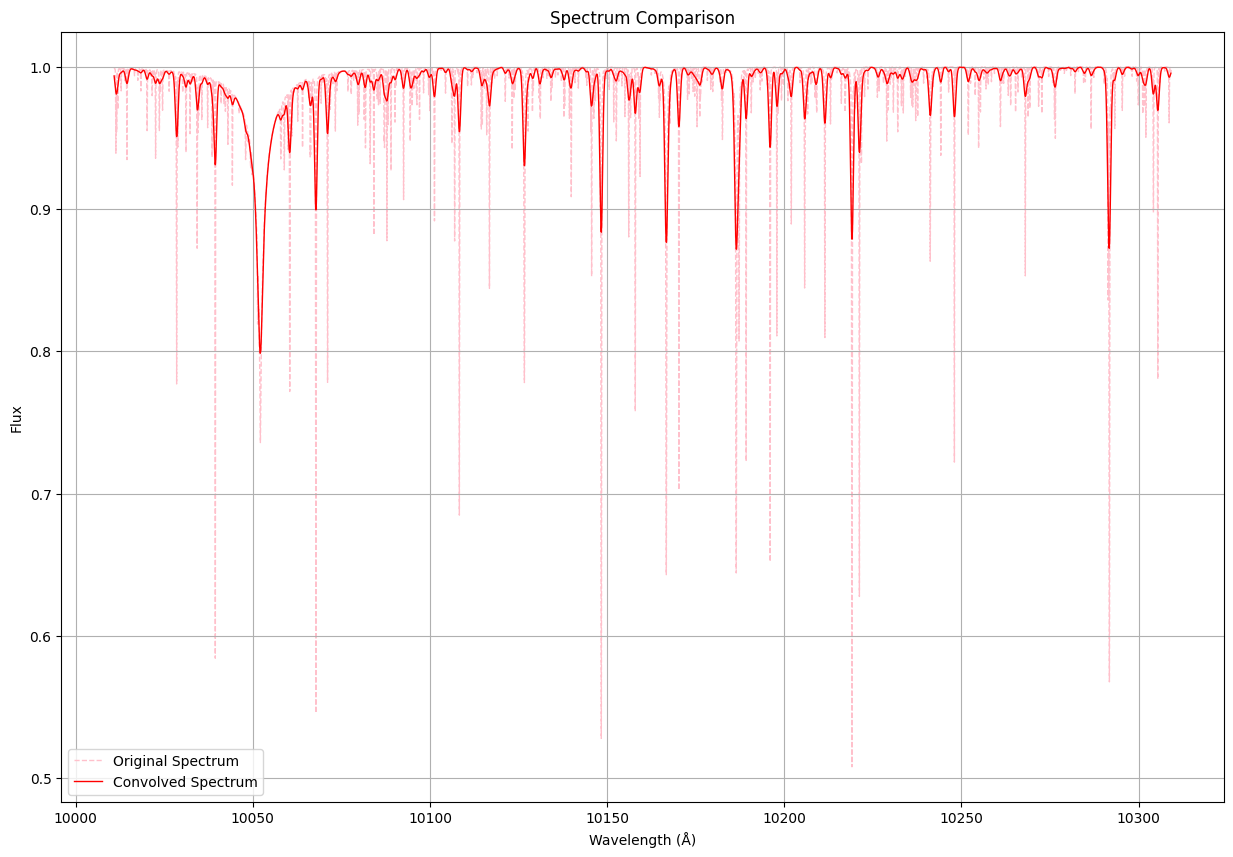

[resample_spectrum] Resampling completed.
[resample_spectrum] First: 10010.85 Å, Center:10159.848009482163 Å, Last: 10308.85 Å
[resample_spectrum] Pixel size: 0.24 Å, New grid points: 1013.


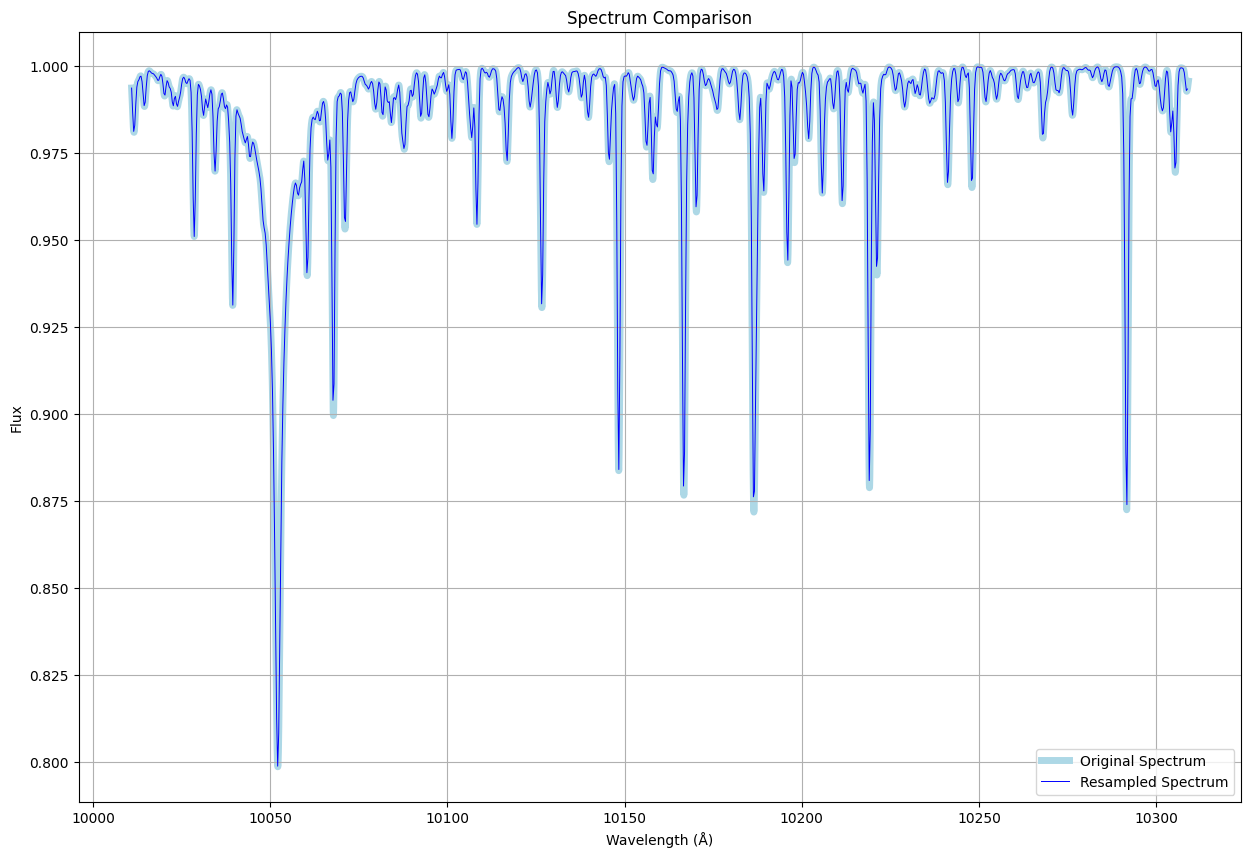

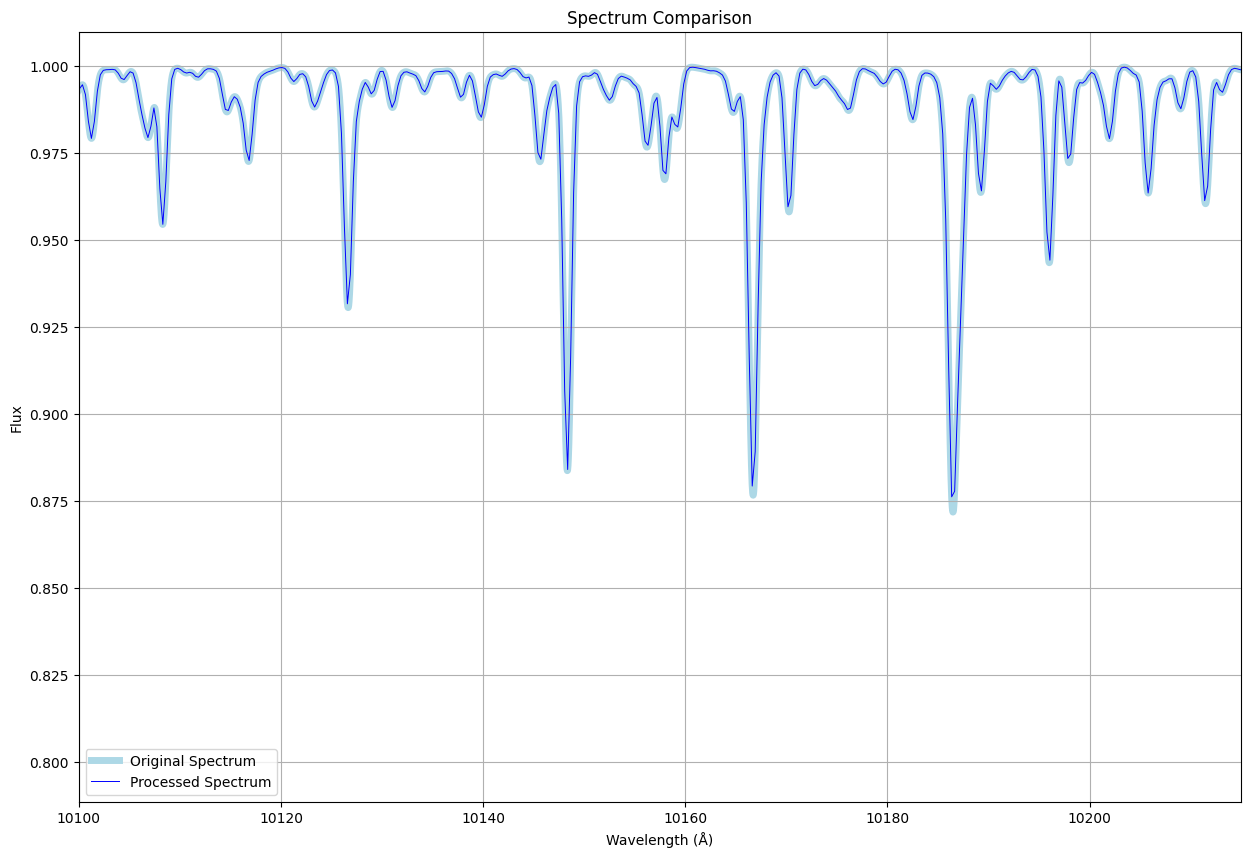

[rescale_flux] Selected central range: 10,130.05–10,189.65 Å
[rescale_flux] Reference flux used: 1.000
[rescale_flux] Max flux after rescaling: 4.001
[rescale_flux] Rescaling completed.


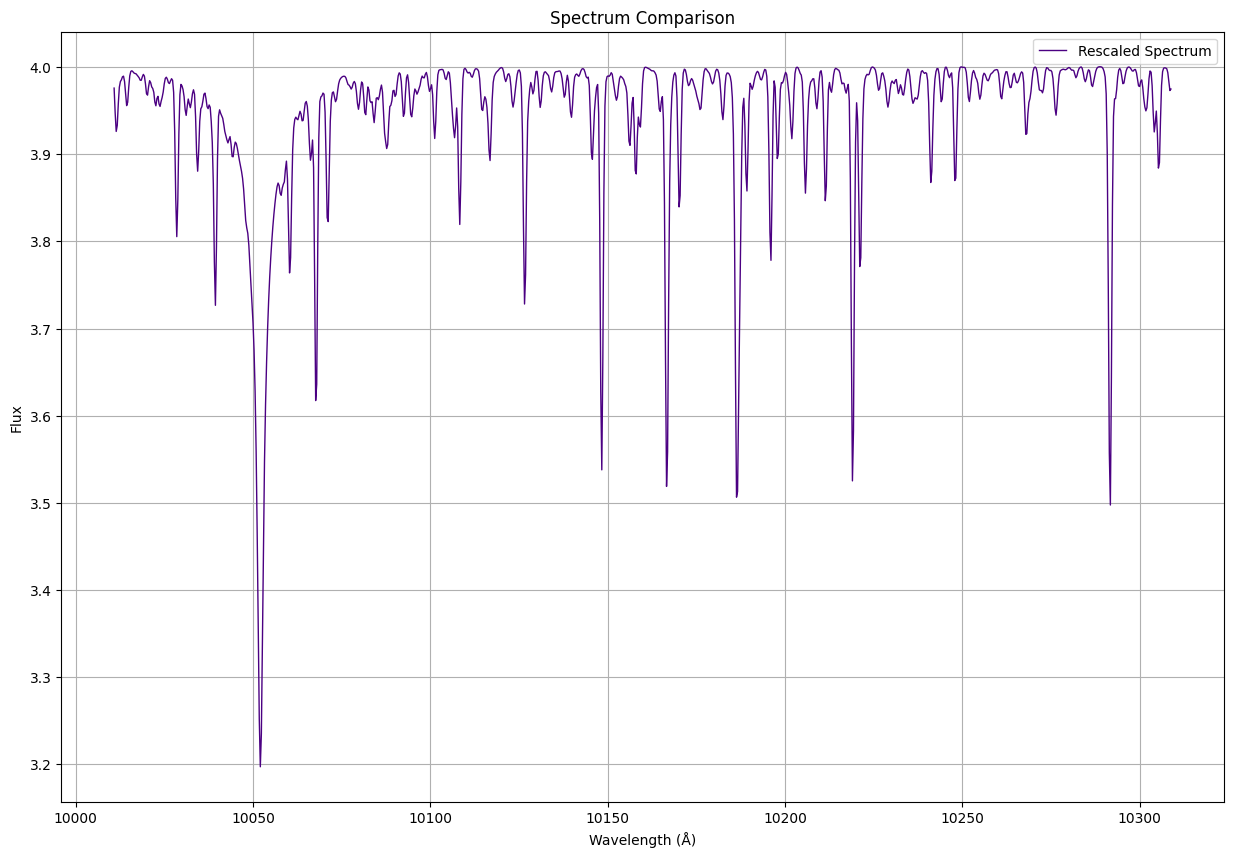

[main] ----------------------------------------------------------------------
[main] Starting iteration 1/1
[radial_velocity_shift] Applying radial velocity shift
[resample_stochastic] Resampling spectrum for stochastic process
[resample_stochastic] Trimmed wavelength range: 10,045.00 Å to 10,274.69 Å
[resample_stochastic] Number of points after trimming: 781


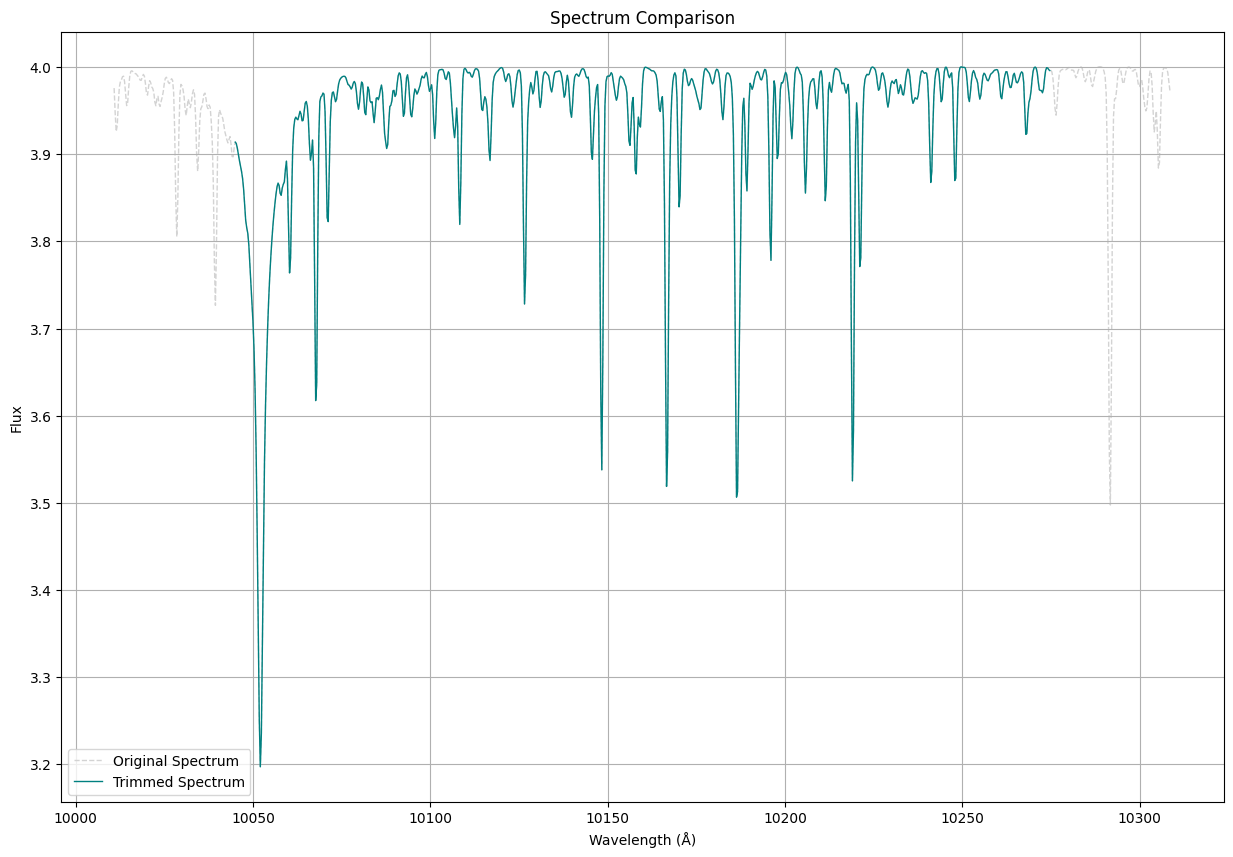

[generate_noise] Noise Generation Completed.
[generate_noise] Mean: 3.96, std: 1.99, estimated snr : 1.99


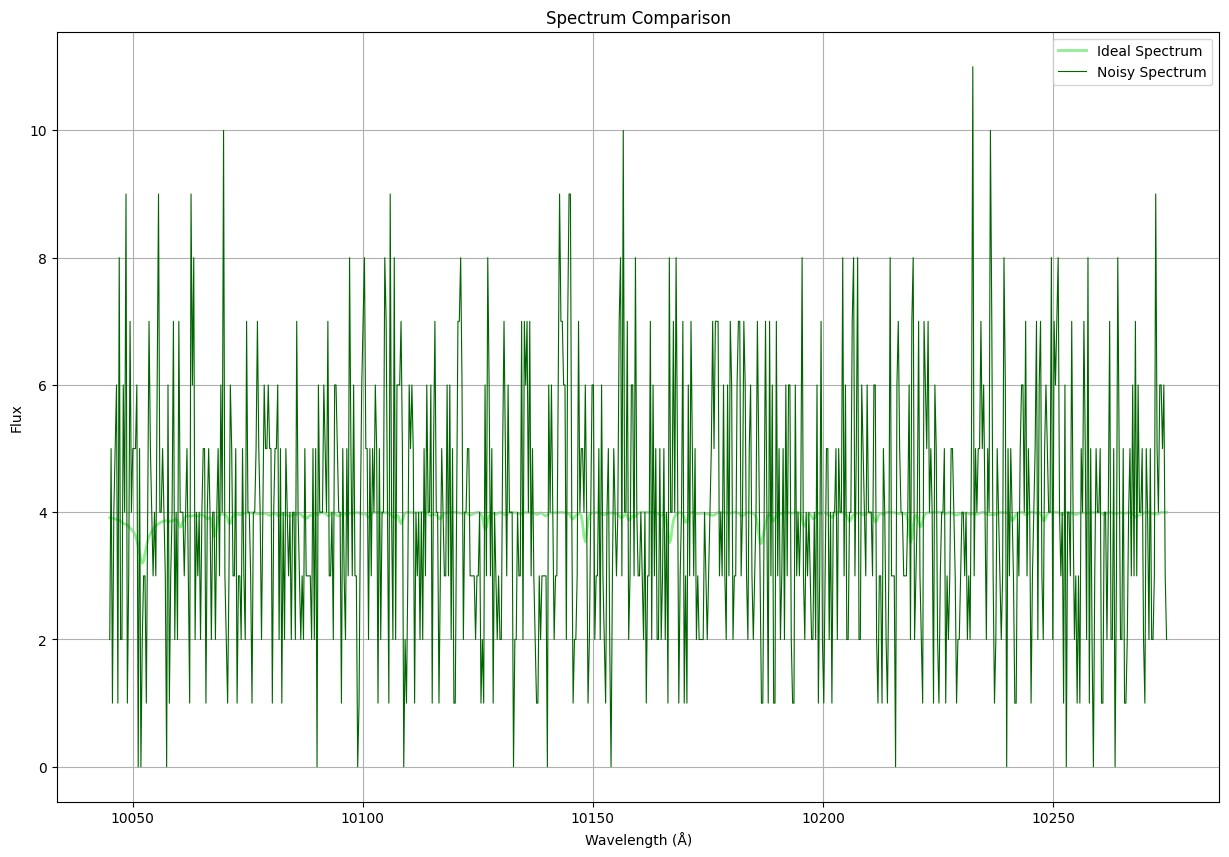

[save_spectrum] Spectrum saved to 'outputs/SNR2/t5700g440a00x10p00_w1001_1031_combined_snr2_0001.txt'.
[main] Simulation complete.


In [24]:
main()